## Data

### Shapefiles

[South America Shapefiles](https://geodata.mit.edu/catalog/stanford-vc965bq8111)
[Mexico and Central America + Carribean](https://geodata.mit.edu/catalog/stanford-cq068zf3261)

### Cities

[here](https://simplemaps.com/data/world-cities)

### Protests
To get the data I used tehh GDELT project and queried from BigQuerry the following SQL

Instructions for the future!

Split the data in two so that you can download the CSVs

**MIGHT NEED TO CHANGE THE SQL BUT FOR NOW IT'S OK**

For `prot_LATAM.csv`
```sql
SELECT
  ActionGeo_CountryCode, ActionGeo_Lat, ActionGeo_Long, ActionGeo_FeatureID, SQLDATE, Year
FROM
  `gdelt-bq.full.events`
WHERE 
  ActionGeo_CountryCode IN("AR","BL","BR","CI","CO","EC","FG","PA","PE","UY","VE","NS","GY")
  AND EventRootCode = '14' -- Subset Protest
```

### Aux files

[fips to ISO2 codes](https://github.com/mysociety/gaze/blob/master/data/fips-10-4-to-iso-country-codes.csv)

In [1]:
#dealing with missings
|ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x | y;
&ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x & y;
!=ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x != y;
==ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x == y;
>=ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x >= y;
<=ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x <= y;
<ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x < y;
>ₘ(x, y) = ismissing(x) | ismissing(y) ? false : x > y;


In [2]:
using CSV, DataFrames, GeoDataFrames, Shapefile, GeoJSON, GeoMakie, CairoMakie, Dates, Rasters, Statistics, ArchGDAL

In [3]:
fips2iso = DataFrame(CSV.File("../data/misc/fips-10-4-to-iso-country-codes.csv"))
rename!(fips2iso, "FIPS10-4" => "fips", "ISO3166" => "iso");

In [4]:
# Load the protests
protests = DataFrame(CSV.File("../data/GDELT/prot_South_America.csv"))

# Change the date variable
protests.month = parse.(Int, [s[5:6] for s in string.(protests.SQLDATE)])
protests.day = parse.(Int, [s[7:8] for s in string.(protests.SQLDATE)])
protests.date = Date.(protests.Year, protests.month, protests.day)
protests.coords = collect(zip(protests.ActionGeo_Long,protests.ActionGeo_Lat))

# rename the country codes to get the iso codes
rename!(protests, :ActionGeo_CountryCode => :fips)
protests = leftjoin(protests, fips2iso, on = :fips)

# Get rid of points that don't have a GeoLocation
sel_no_geo = .!ismissing.(protests.ActionGeo_FeatureID)
protests = protests[sel_no_geo,:]

# get rid of those points assign to the whole country and not a specific location
sel_country_points = occursin.(Ref(r"^[-\d]+$"), protests.ActionGeo_FeatureID)
protests = protests[sel_country_points,:]

# Create a geometry variable
protests.geometry = createpoint.(protests.coords)

order_variables = [:geometry]

protests = select(protests, order_variables, Not(order_variables))

Row,geometry,fips,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,SQLDATE,Year,month,day,date,coords,iso,Name
,IGeometr…,String3,Float64,Float64,String15?,Int64,Int64,Int64,Int64,Date,Tuple…,String3?,String?
1,Geometry: wkbPoint,CO,9.11063,-73.447,270089,20050808,2005,8,8,2005-08-08,"(-73.447, 9.11063)",CO,Colombia
2,Geometry: wkbPoint,CO,9.23372,-75.374,-599173,20110103,2011,1,3,2011-01-03,"(-75.374, 9.23372)",CO,Colombia
3,Geometry: wkbPoint,BR,-5.95,-39.3667,-652348,20050422,2005,4,22,2005-04-22,"(-39.3667, -5.95)",BR,Brazil
4,Geometry: wkbPoint,BR,-7.95,-34.8833,-660221,20151214,2015,12,14,2015-12-14,"(-34.8833, -7.95)",BR,Brazil
5,Geometry: wkbPoint,BR,-12.9833,-38.5167,-667833,20151104,2015,11,4,2015-11-04,"(-38.5167, -12.9833)",BR,Brazil
6,Geometry: wkbPoint,BL,-17.9833,-67.15,-696251,20110211,2011,2,11,2011-02-11,"(-67.15, -17.9833)",BO,Bolivia
7,Geometry: wkbPoint,GY,6.8094,-58.1615,-922968,20130228,2013,2,28,2013-02-28,"(-58.1615, 6.8094)",GY,Guyana
8,Geometry: wkbPoint,GY,6.8094,-58.1615,-922968,20150402,2015,4,2,2015-04-02,"(-58.1615, 6.8094)",GY,Guyana
9,Geometry: wkbPoint,EC,-1.25,-78.5167,-930385,19981001,1998,10,1,1998-10-01,"(-78.5167, -1.25)",EC,Ecuador


In [5]:
# Cities database
cities_df = DataFrame(CSV.File("../data/geometries/cities/worldcities.csv"))

# Get the codes from the cities in protests
country_list = Set(protests.iso)
LATAM_sel = in.(cities_df.iso2, Ref(country_list))

# Get those that are big (more than 1000k)
pop_sel = in.(cities_df.capital, Ref(["primary"]))

cities_df = cities_df[LATAM_sel .&& pop_sel,:]

# Create the geometries
cities_df.geometry = createpoint.(collect(zip(cities_df.lng,cities_df.lat)))

GeoDataFrames.write("../data/geometries/cities/south_america_cities.geojson", cities_df[:,["geometry"]]; crs=GeoFormatTypes.EPSG(3857))
cities_latam  = GeoJSON.read("../data/geometries/cities/south_america_cities.geojson")

FeatureCollection with 14 Features

In [6]:
# Shapefiles
south_america_geo = GeoDataFrames.read("../data/geometries/SOUTH_AMERICA/SouthAmerica.shp")
# south_america_geo.geometry = ArchGDAL.simplifypreservetopology.(south_america_geo.geometry, Ref(1))
rename!(south_america_geo, :Name => :NAME)

# sel by the countries
sel = in.(south_america_geo.	iso_alpha2, Ref(country_list))
south_america_geo = south_america_geo[sel, :]

# Need to transform it to GeoJSON to use Table.jl instead of GDAL types
GeoDataFrames.write("../data/geometries/SOUTH_AMERICA/south_america.geojson", south_america_geo[:,["geometry"]]; crs=GeoFormatTypes.EPSG(3857))
South_america_poly  = GeoJSON.read("../data/geometries/SOUTH_AMERICA/south_america.geojson")

FeatureCollection with 11354 Features

In [7]:
# Transform from points to raster data
protest_raster = rasterize(count, protests.geometry; res = 1, boundary=:touches)
protest_raster = rebuild(protest_raster; missingval=0)

# Get the uantiles of the data
quantiles = collect(.1:.1:.9)
vectorized = DataFrame(vals = collect(protest_raster)[:])
allowmissing!(vectorized)
vectorized= vectorized[vectorized.vals .!= 0,:]
quantile_values = quantile(vectorized.vals, quantiles)

classes =   <=(quantile_values[1]) => 1,
            quantile_values[1]..quantile_values[2] => 2,
            quantile_values[2]..quantile_values[3] => 3,
            quantile_values[3]..quantile_values[4] => 4,
            quantile_values[4]..quantile_values[5] => 5,
            quantile_values[5]..quantile_values[6] => 6,
            quantile_values[6]..quantile_values[7] => 7,
            quantile_values[7]..quantile_values[8] => 8,
            quantile_values[8]..quantile_values[9] => 8,
            >(quantile_values[9]) => 10
classify!(protest_raster, classes; others=0, missingval=0)

# Create a mask for the raster
masked_raster = mask(protest_raster; with = South_america_poly)
plot_rater = trim(masked_raster)

   0%|█                                                 |  ETA: 2:10:44

┌ Info: A geometry was ignored at Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-28.845388412475586, -28.84148597717285), Y = (-20.496889114379883, -20.493749618530273))) as it was outside of the supplied extent Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-109.45, -29.3217), Y = (-55.9833, 13.3833)))
└ @ Rasters C:\Users\48672590\.julia\packages\Rasters\nC6xb\src\methods\burning\geometry.jl:111
┌ Info: A geometry was ignored at Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-28.85047149658203, -28.842971801757812), Y = (-20.478763580322266, -20.471277236938477))) as it was outside of the supplied extent Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-109.45, -29.3217), Y = (-55.9833, 13.3833)))
└ @ Rasters C:\Users\48672590\.julia\packages\Rasters\nC6xb\src\methods\burning\geometry.jl:111
┌ Info: A geometry was ignored a

┌ Info: A geometry was ignored at Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-68.73747253417969, -68.73252868652344), Y = (-56.45708465576172, -56.45455551147461))) as it was outside of the supplied extent Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-109.45, -29.3217), Y = (-55.9833, 13.3833)))
└ @ Rasters C:\Users\48672590\.julia\packages\Rasters\nC6xb\src\methods\burning\geometry.jl:111
  90%|██████████████████████████████████████████████    |  ETA: 0:00:00

┌ Info: A geometry was ignored at Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-109.46044158935547, -109.4562759399414), Y = (-27.202943801879883, -27.198749542236328))) as it was outside of the supplied extent Extents.Extent{(:X, :Y), Tuple{Tuple{Float64, Float64}, Tuple{Float64, Float64}}}((X = (-109.45, -29.3217), Y = (-55.9833, 13.3833)))
└ @ Rasters C:\Users\48672590\.julia\packages\Rasters\nC6xb\src\methods\burning\geometry.jl:111
 100%|██████████████████████████████████████████████████| Time: 0:00:02


┌ Info: 11329 geometries did not affect any pixels. See `metadata(raster)["missed_geometries"]` for a vector of misses
└ @ Rasters C:\Users\48672590\.julia\packages\Rasters\nC6xb\src\methods\burning\allocs.jl:38


46×68 Raster{Int64,2} count with dimensions: 
  X Projected{Float64} -80.76209012345679:0.9892382716049383:-36.24636790123457 ForwardOrdered Regular Intervals{Start},
  Y Projected{Float64} -54.99234857142857:0.9909514285714286:11.401397142857142 ForwardOrdered Regular Intervals{Start}
extent: Extent(X = (-80.76209012345679, -35.25712962962963), Y = (-54.99234857142857, 12.39234857142857))missingval: 0parent:
           -54.9923  -54.0014  …  8.42854  9.41949  10.4104  11.4014
 -80.7621    0         0          0        0         0        0
 -79.7729    0         0          0        0         0        0
 -78.7836    0         0          0        0         0        0
 -77.7944    0         0          0        0         0        0
 -76.8051    0         0       …  5        0         0        0
   ⋮                           ⋱                     ⋮       
 -41.1926    0         0          0        0         0        0
 -40.2033    0         0          0        0         0        0
 -39.214

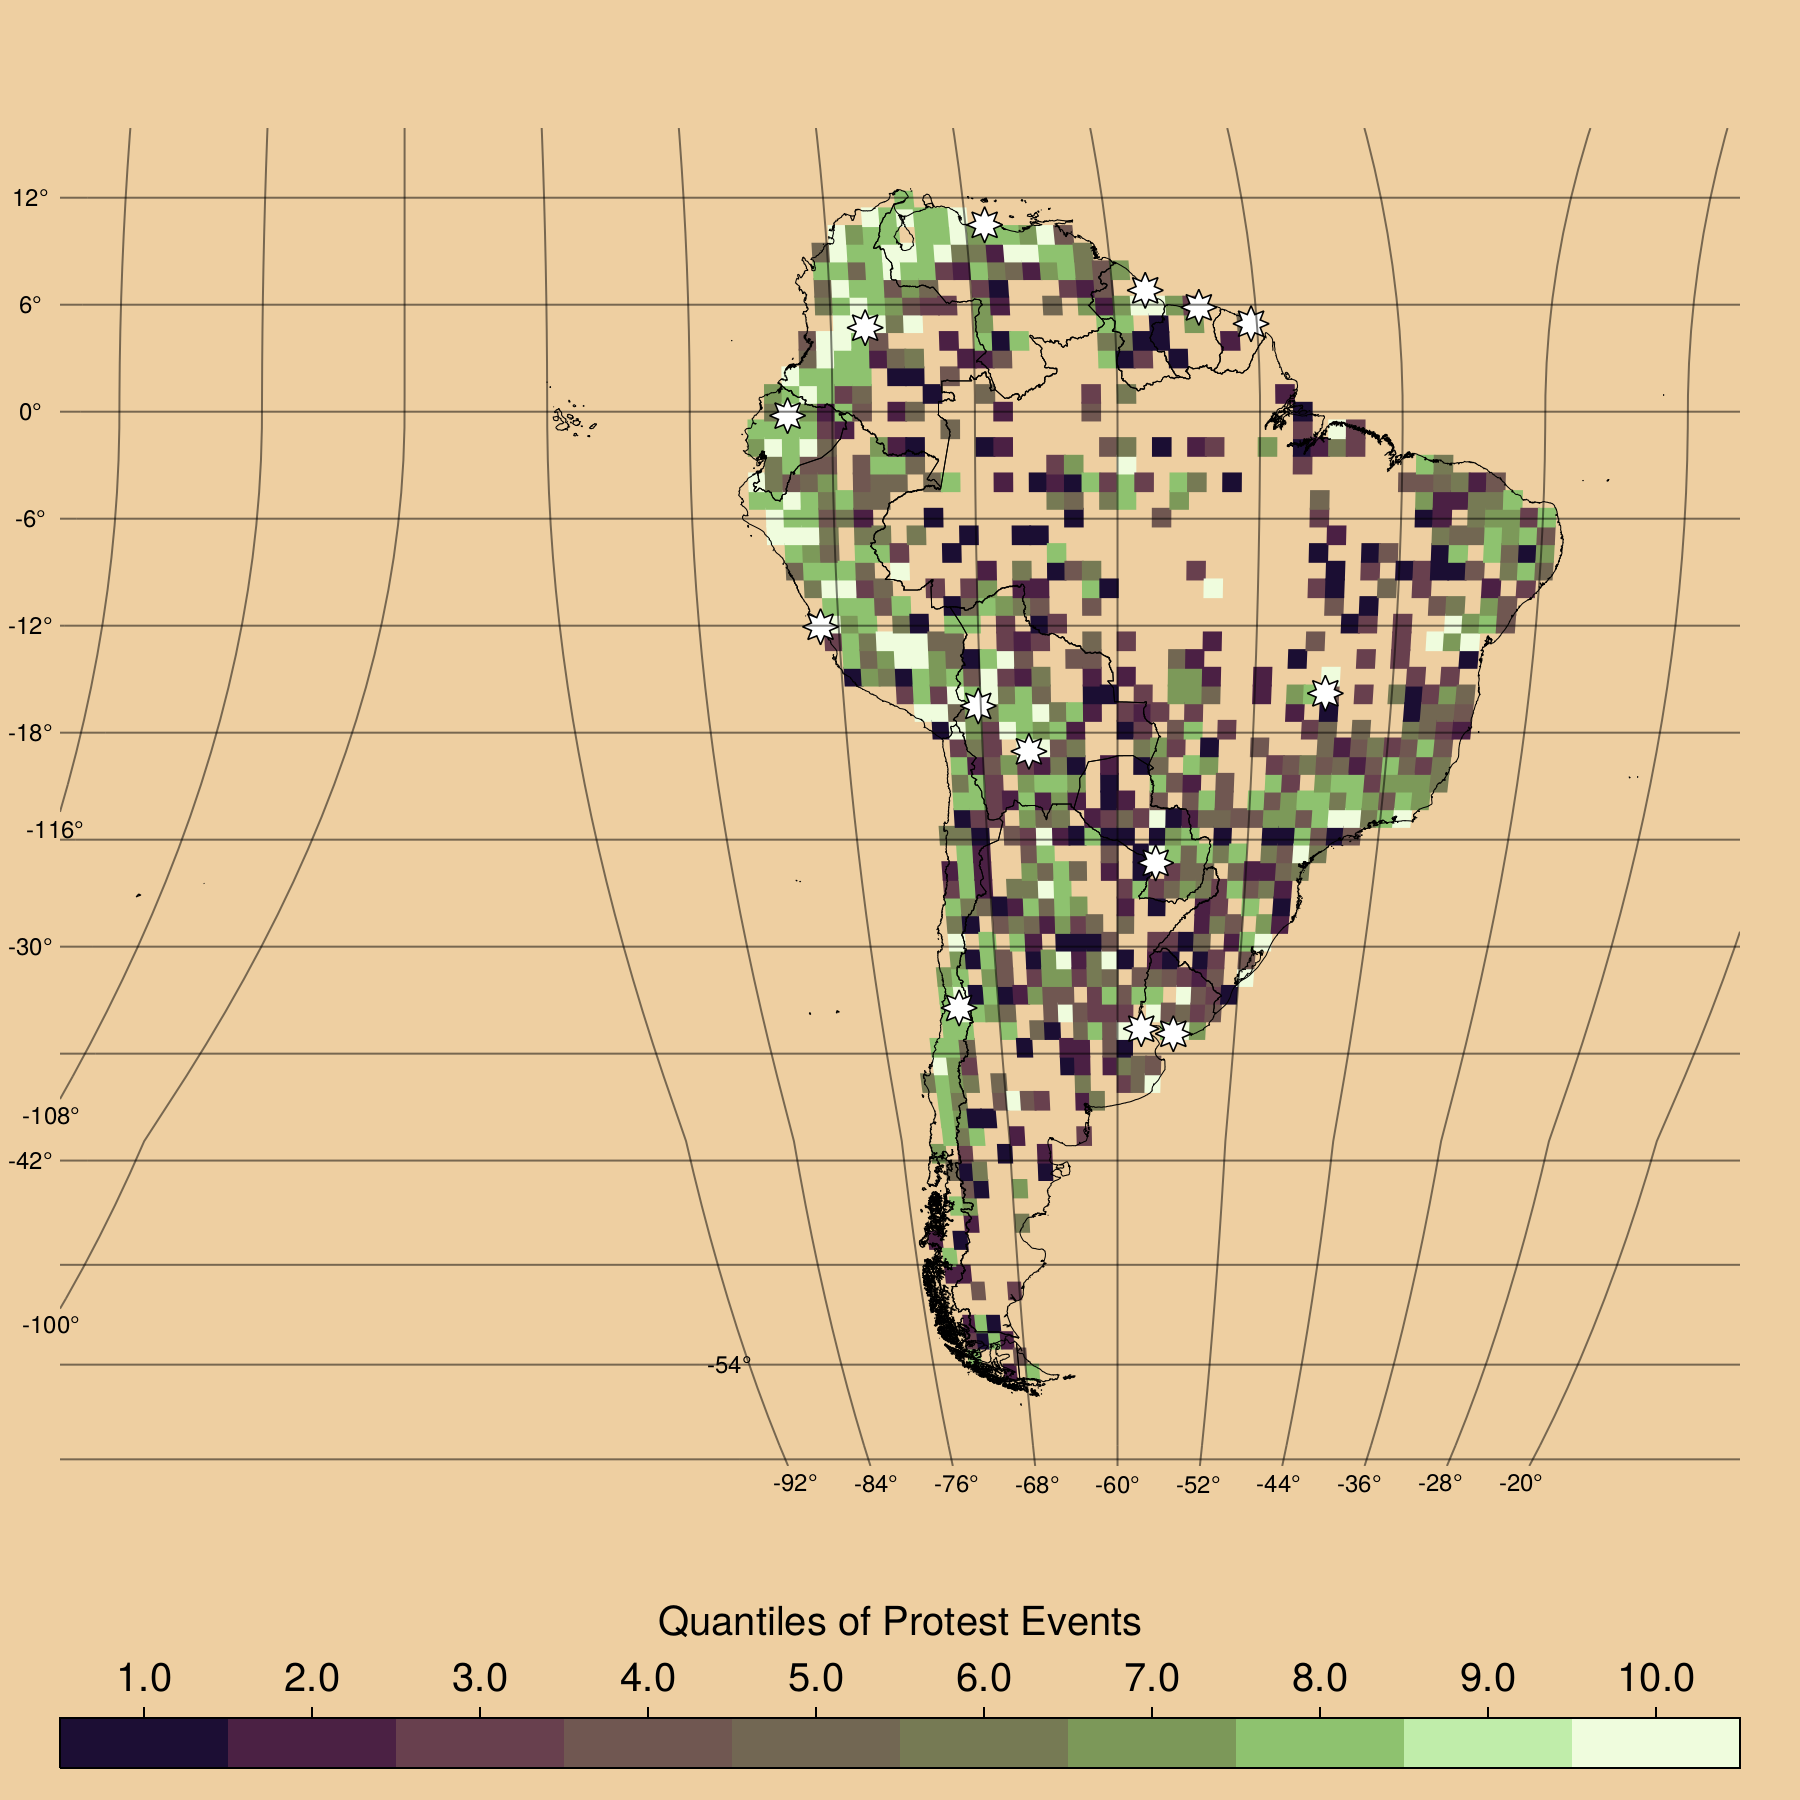

In [33]:
fig = Figure(
    size = (900, 900),
    backgroundcolor = :navajowhite2,
    fontsize = 20
)
ga = GeoAxis(
    fig[1, 1]; # any cell of the figure's layout
    dest = "+proj=igh", # This one is cool looking
    # dest = "+proj=merc",
    xticklabelsize = 12, yticklabelsize = 12
)

phet = heatmap!(ga, plot_rater;
                colormap = Makie.Categorical(:tokyo))

poly!(ga, South_america_poly;  
      color = :transparent, strokewidth = .5, strokecolor = :black)
scatter!(ga, cities_latam;
         color = :white, marker = :star8, markersize = 20, strokewidth = .8,
         label = "Capital cities")

Colorbar(fig[2, :], phet; 
         vertical = false, size = 25, label = "Quantiles of Protest Events")

# Put an issue so that it can be resolved
# ylims!(ga,-90,90)
# xlims!(ga,-90,90)

fig